In [28]:
import os
from copy import deepcopy

import numpy as np
import openml
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from fastkan import FastKAN
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer, StandardScaler
from torch.distributions.categorical import Categorical
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, TensorDataset, Dataset
from tqdm import tqdm

from src.kans.ekan import KAN

## Copying ShapleySampler class

In [29]:
#I don't seem to be able to find the exact source for the fastshap.utils ShapleySampler class, so I'll just use one I got from here: https://github.com/iclr1814/fastshap/blob/master/fastshap_torch/fastshap.py
# hope it's the same...

class ShapleySampler:
    '''
    For sampling player subsets from the Shapley distribution.

    Args:
      num_players:
    '''

    def __init__(self, num_players):
        arange = torch.arange(1, num_players)
        w = 1 / (arange * (num_players - arange))
        w = w / torch.sum(w)
        self.categorical = Categorical(probs=w)
        self.num_players = num_players
        self.tril = torch.tril(
            torch.ones(num_players - 1, num_players, dtype=torch.float32),
            diagonal=0)

    def sample(self, batch_size, paired_sampling):
        '''
        Generate sample.

        Args:
          batch_size:
          paired_sampling:
        '''
        num_included = 1 + self.categorical.sample([batch_size])
        S = self.tril[num_included - 1]
        # TODO ideally avoid for loops
        # TODO can't figure out how to shuffle rows independently
        # TODO don't want to generate paired samples in parallel and force even num_samples
        for i in range(batch_size):
            if paired_sampling and i % 2 == 1:
                S[i] = 1 - S[i - 1]
            else:
                S[i] = S[i, torch.randperm(self.num_players)]
        return S


def additive_efficient_normalization(pred, grand, null):
    '''
    Apply additive efficient normalization.

    Args:
      pred: 
      grand:
      null:
    '''
    gap = (grand - null) - torch.sum(pred, dim=1)
    return pred + gap.unsqueeze(1) / pred.shape[1]


def calculate_grand_coalition(x, imputer, batch_size, link, device):
    '''
    Calculate the value of grand coalition for each x.

    Args:
      x:
      imputer:
      batch_size:
      num_players:
      link:
      device:
    '''
    ones = torch.ones(batch_size, imputer.num_players, dtype=torch.float32,
                      device=device)
    with torch.no_grad():
        grand = []
        for i in range(int(np.ceil(len(x) / (batch_size)))):
            start = i * batch_size
            end = min(start + batch_size, len(x))
            grand.append(link(
                imputer(x[start:end].to(device), ones[:(end-start)])))

        # Concatenate and return.
        grand = torch.cat(grand)
        if len(grand.shape) == 1:
            grand = grand.reshape(-1, 1)

    return grand


def validate(val_loader, imputer, explainer, null, link, normalization):
    '''
    Calculate mean validation loss.

    Args:
      val_loader:
      imputer:
      explainer:
      null:
      link:
      normalization:
    '''
    with torch.no_grad():
        # Setup.
        device = next(explainer.parameters()).device
        mean_loss = 0
        N = 0
        loss_fn = nn.MSELoss()

        for x, grand, S, values in val_loader:
            # Move to device.
            x = x.to(device)
            S = S.to(device)
            grand = grand.to(device)
            values = values.to(device)

            # Evaluate explainer.
            pred = explainer(x)
            pred = pred.reshape(len(x), imputer.num_players, -1)
            if normalization:
                pred = normalization(pred, grand, null)

            # Evaluate loss.
            approx = null + torch.matmul(S, pred)
            loss = loss_fn(approx, values)

            # Update average.
            N += len(x)
            mean_loss += (loss - mean_loss) / N

    return mean_loss

## Model Training

In [30]:
class EarlyStopping:
    def __init__(self, patience=20, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.best_epoch = None
        self.counter = 0

    def __call__(self, val_loss, epoch):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_epoch = epoch
            return False

        if val_loss <= self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.best_epoch = epoch
            self.counter = 0
            return False
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
            return False


class Embed(nn.Module):
    def __init__(self, dataframe, categorical, numerical, emb_dim):
        super(Embed, self).__init__()

        self.categorical = categorical
        self.numerical = numerical
        self.emb_dim = emb_dim

        # Create a dictionary to store embeddings for each categorical column
        self.embedding_dict = nn.ModuleDict()

        for col in self.categorical:
            num_emb = dataframe[col].nunique()
            self.embedding_dict[col] = nn.Embedding(num_emb + 1, emb_dim)

        # Linear layer for numerical features
        # self.fc_numerical = nn.Linear(1, emb_dim)

    def forward(self, x):
        if len(self.categorical) > 0:
            if len(self.numerical) > 0:
                numerical_x = x[:, :len(self.numerical)]
                nominal_x = x[:, len(self.numerical):]

                # List to store embeddings for each categorical column
                embedded = [self.embedding_dict[col](nominal_x[:, i].long()) for i, col in
                            enumerate(self.categorical)]
                nominal_x = torch.cat(embedded, dim=1)

                # Apply linear transformation to numerical features
                # numerical_x = self.fc_numerical(numerical_x)

                # Concatenate numerical and categorical embeddings
                embedded_x = torch.cat([numerical_x, nominal_x], dim=1)
            else:
                nominal_x = x
                # List to store embeddings for each categorical column
                embedded = [self.embedding_dict[col](nominal_x[:, i].long()) for i, col in
                            enumerate(self.categorical)]
                embedded_x = torch.cat(embedded, dim=1)
        else:
            embedded_x = x  # self.fc_numerical(x)

        return embedded_x


class KANSHAP(nn.Module):
    def __init__(self, num_features, num_classes, index_to_name, dataframe, categorical, numerical, link_func=False, add_bias=True, kan_type="ekan"):
        super(KANSHAP, self).__init__()

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.embedding = Embed(dataframe, categorical, numerical, 32)

        if kan_type == "ekan":
            self.f1 = KAN([len(categorical) * 32 + len(numerical), 64, 128, 64, num_features * num_classes],
                          grid_size=5, spline_order=3)
        elif kan_type == "fkan":
            self.f1 = FastKAN([len(categorical) * 32 + len(numerical), 64, 128, 64, num_features * num_classes],
                           grid_num=6)

        self.num_classes = num_classes
        self.num_features = num_features

        self.link_func = link_func
        self.add_bias = add_bias

        if add_bias:
            self.delta = torch.nn.init.uniform_(Parameter(torch.FloatTensor(num_classes)), -0.1, 0.1)

        self.O = torch.ones(self.num_features, 1, requires_grad=False).to(device)

        if link_func:
            self.sigmoid = nn.Sigmoid()
            self.softmax = nn.Softmax(dim=1)

        self.index_to_name = index_to_name

    def kan_forward(self, x_in):

        x = self.embedding(x_in)

        x = self.f1(x)

        return x

    def predict_class(self, x):

        if self.num_classes > 1:
            x = x.view(x.size(0), self.num_classes, self.num_features) @ self.O

            if self.add_bias:
                x = torch.squeeze(x, 2) + self.delta
            else:
                x = torch.squeeze(x, 2)
            if self.link_func:
                x = self.softmax(x)
        else:
            if self.add_bias:
                x = torch.mm(x.view(x.size(0), x.size(1)), self.O) + self.delta
            else:
                x = torch.mm(x.view(x.size(0), x.size(1)), self.O)
            if self.link_func:
                x = self.sigmoid(x)
        return x

    def forward(self, x_in):
        x = self.kan_forward(x_in)

        x = self.predict_class(x)

        return x

    def predict(self, x_in):
        with torch.no_grad():
            return self.forward(x_in)
        
    def get_shapley_values(self, x_in):

        if self.num_classes > 1:
            y = self.forward(x_in)
            y = np.argmax(y[0].cpu().detach().numpy())

            x = self.kan_forward(x_in)
            x = x.view(x.size(0), self.num_classes, self.num_features)
            x = x[:, y]
        else:
            x = self.kan_forward(x_in)
            x = x.view(x.size(0), x.size(1))

        return x.cpu().data.numpy()

    def get_local_importance(self, x_in):

        if self.num_classes > 1:
            y = self.forward(x_in)
            y = np.argmax(y[0].cpu().detach().numpy())

            x = self.kan_forward(x_in)
            x = x.view(x.size(0), self.num_classes, self.num_features)
            x = x[:, y].reshape(-1)
        else:
            x = self.kan_forward(x_in)
            x = x.view(x.size(0), x.size(1)).reshape(-1)

        return x.cpu().data.numpy()

    def plot_bars(self, normalized_instance, instance, num_f):
        import matplotlib.pyplot as plt

        local_importance = self.get_local_importance(normalized_instance)

        original_values = instance.to_dict()

        names = []
        values = []
        for i, v in enumerate(local_importance):
            name = self.index_to_name[i]
            names.append(name)
            values.append(v)

        feature_local_importance = {}
        for i, v in enumerate(values):
            feature_local_importance[self.index_to_name[i]] = v

        feature_names = [f'{name} = {original_values[name]}' for name, val in sorted(feature_local_importance.items(),
                                                                                     key=lambda item: abs(item[1]))]
        feature_values = [val for name, val in sorted(feature_local_importance.items(),
                                                      key=lambda item: abs(item[1]))]

        plt.style.use('ggplot')
        plt.rcParams.update({'font.size': 12, 'font.weight': 'bold'})

        # if self.num_classes > 2:
        #    center = 0
        # else:
        #   center = self.beta.item()
        plt.barh(feature_names[-num_f:], feature_values[-num_f:], left=0,
                 color=np.where(np.array(feature_values[-num_f:]) < 0, 'dodgerblue', '#f5054f'))

        for index, v in enumerate(feature_values[-num_f:]):
            if v > 0:
                plt.text(v + 0, index, "+{:.2f}".format(v), ha='center')
            else:
                plt.text(v + 0, index, "{:.2f}".format(v), ha='left')

        plt.xlabel('Importance')
        plt.rcParams["figure.figsize"] = (8, 8)

        plt.show()


def train_model(index_to_name, train_dataloader,
                val_dataloader, data_name, num_classes,
                dataframe, categorical, numerical,
                kan_model=None, optimizer_train=None, current_epoch=1,
                max_num_epochs=300, learning_rate=1e-03, num_samples=32,
                alpha=0.5, beta=0.5,
                link_func=False, add_bias=True,
                efficiency_constraint=True, patience=20):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    num_features = len(index_to_name)

    sampler = ShapleySampler(num_features)

    if not os.path.exists(f'{data_name}'):
        os.makedirs(f'{data_name}')

    mse_loss = nn.MSELoss()
    loss_function = nn.MSELoss()
    softmax = nn.Softmax(dim=1)
    if link_func and num_classes < 2:
        loss_function = nn.BCELoss()

    early_stopping = EarlyStopping(patience=patience)

    if kan_model is None:
        kan_model = KANSHAP(num_features, num_classes, index_to_name, dataframe, categorical,
                            numerical, link_func, add_bias).to(device)
    if optimizer_train is None:
        optimizer_train = torch.optim.Adam(kan_model.parameters(), lr=learning_rate)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer_train, factor=0.5, patience=patience // 3, min_lr=1e-6,
        # verbose=True
    )

    best_val_loss = np.inf

    for epoch in range(current_epoch, max_num_epochs + 1):
        kan_model.train()

        train_loss = 0
        train_count = 0

        train_labels = []

        for i, data in enumerate(tqdm(train_dataloader)):
            inputs, labels = data

            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer_train.zero_grad()

            outputs = kan_model(inputs)

            if efficiency_constraint:
                zeros = torch.zeros(1, num_features, dtype=torch.float32,
                                    device=device)

                null = kan_model(zeros)

            S = sampler.sample(inputs.shape[0] * num_samples,
                               paired_sampling=True)
            S = S.reshape((inputs.shape[0] * num_samples, num_features)).to(device)

            input_tiled = inputs.unsqueeze(1).repeat(
                1, num_samples, *[1 for _ in range(len(inputs.shape) - 1)]
            ).reshape(inputs.shape[0] * num_samples, *inputs.shape[1:]).to(device)

            sampled_inputs = input_tiled * S

            sampled_ouput = kan_model(sampled_inputs)

            scores = kan_model.kan_forward(inputs)

            if num_classes > 1:
                scores_tiled = scores.unsqueeze(1).repeat(
                    1, num_samples, *[1 for _ in range(len(inputs.shape) - 1)]
                ).reshape(inputs.shape[0] * num_samples, num_classes, *inputs.shape[1:]).to(device)

                S = S.unsqueeze(1)
            else:
                scores_tiled = scores.unsqueeze(1).repeat(
                    1, num_samples, *[1 for _ in range(len(inputs.shape) - 1)]
                ).reshape(inputs.shape[0] * num_samples, *inputs.shape[1:]).to(device)

            sampled_scores = scores_tiled * S
            if num_classes > 1:
                sampled_scores = sampled_scores.view(sampled_scores.size(0), num_classes, num_features) @ kan_model.O
                sampled_scores = torch.squeeze(sampled_scores, 2)
                if link_func:
                    sampled_scores = kan_model.softmax(sampled_scores)
            else:
                sampled_scores = torch.mm(sampled_scores.view(sampled_scores.size(0), sampled_scores.size(1)), kan_model.O)
                if link_func:
                    sampled_scores = kan_model.sigmoid(sampled_scores)

            if efficiency_constraint:
                sampled_scores_output = null + sampled_scores
            else:
                sampled_scores_output = sampled_scores

            if num_classes > 1:

                loss = alpha * loss_function(outputs, labels) + beta * mse_loss(sampled_scores_output,
                                                                                     sampled_ouput)
                preds = torch.max(outputs, dim=-1)[1]
                train_count += torch.sum(preds == torch.max(labels, dim=-1)[1])
            else:

                loss = alpha * loss_function(outputs.reshape(-1), labels.float()) + \
                       beta * mse_loss(sampled_scores_output.reshape(-1), sampled_ouput.reshape(-1))
                preds = (outputs.reshape(-1) > 0.5) * 1
                train_count += torch.sum(preds == labels.data)

            train_loss += loss.item()  # * output.shape[0]

            loss.backward()
            optimizer_train.step()
            train_labels.extend(labels.tolist())

            del inputs, labels, data, outputs, S, input_tiled, sampled_inputs, sampled_ouput, scores, scores_tiled, sampled_scores, sampled_scores_output

            torch.cuda.empty_cache()

        kan_model.eval()

        val_count = 0
        val_loss = 0.0

        list_prediction = []
        val_labels = []
        list_prob_pred = []

        bce_loss = []
        int_loss = []
        with torch.no_grad():
            for i, data in enumerate(tqdm(val_dataloader)):
                inputs, labels = data

                inputs = inputs.to(device)
                labels = labels.to(device)

                if efficiency_constraint:
                    zeros = torch.zeros(1, num_features, dtype=torch.float32,
                                        device=device)

                    null = kan_model(zeros)

                S = sampler.sample(inputs.shape[0] * num_samples,
                                   paired_sampling=True)
                S = S.reshape((inputs.shape[0] * num_samples, num_features)).to(device)

                input_tiled = inputs.unsqueeze(1).repeat(
                    1, num_samples, *[1 for _ in range(len(inputs.shape) - 1)]
                ).reshape(inputs.shape[0] * num_samples, *inputs.shape[1:]).to(device)

                sampled_inputs = input_tiled * S

                sampled_ouput = kan_model(sampled_inputs)

                scores = kan_model.kan_forward(inputs)

                if num_classes > 1:
                    scores_tiled = scores.unsqueeze(1).repeat(
                        1, num_samples, *[1 for _ in range(len(inputs.shape) - 1)]
                    ).reshape(inputs.shape[0] * num_samples, num_classes, *inputs.shape[1:]).to(device)

                    S = S.unsqueeze(1)
                else:
                    scores_tiled = scores.unsqueeze(1).repeat(
                        1, num_samples, *[1 for _ in range(len(inputs.shape) - 1)]
                    ).reshape(inputs.shape[0] * num_samples, *inputs.shape[1:]).to(device)

                sampled_scores = scores_tiled * S
                if num_classes > 1:
                    sampled_scores = sampled_scores.view(sampled_scores.size(0), num_classes, num_features) @ kan_model.O
                    sampled_scores = torch.squeeze(sampled_scores, 2)
                    if link_func:
                        sampled_scores = kan_model.softmax(sampled_scores)
                else:
                    sampled_scores = torch.mm(sampled_scores.view(sampled_scores.size(0), sampled_scores.size(1)), kan_model.O)
                    if link_func:
                        sampled_scores = kan_model.sigmoid(sampled_scores)

                if efficiency_constraint:
                    sampled_scores_output = null + sampled_scores
                else:
                    sampled_scores_output = sampled_scores

                outputs = kan_model(inputs)

                if num_classes > 1:
                    if not link_func:
                        outputs = softmax(outputs)
                    bce_loss.append(alpha * mse_loss(outputs, labels))
                    int_loss.append(beta * mse_loss(sampled_scores_output, sampled_ouput))

                    val_loss += (alpha * mse_loss(outputs, labels) + beta * mse_loss(sampled_scores_output,
                                                                                               sampled_ouput))
                    preds = torch.max(outputs, dim=-1)[1]
                    val_count += torch.sum(preds == torch.max(labels, dim=-1)[1])
                    val_labels.extend(torch.max(labels, dim=-1)[1].tolist())
                    list_prob_pred.extend(outputs.tolist())
                else:
                    bce_loss.append(alpha * loss_function(outputs.reshape(-1), labels.float()))
                    int_loss.append(beta * mse_loss(sampled_scores_output.reshape(-1), sampled_ouput.reshape(-1)))

                    val_loss += (alpha * loss_function(outputs.reshape(-1), labels.float()) + \
                                 beta * mse_loss(sampled_scores_output.reshape(-1), sampled_ouput.reshape(-1)))
                    preds = (outputs.reshape(-1) > 0.5) * 1
                    val_count += torch.sum(preds == labels.data)
                    val_labels.extend(labels.tolist())

                list_prediction.extend(preds.tolist())

                del inputs, labels, outputs, preds, S, input_tiled, sampled_inputs, sampled_ouput, scores, scores_tiled, sampled_scores, sampled_scores_output
                torch.cuda.empty_cache()

        if num_classes > 2:
            roc = roc_auc_score(
                val_labels,
                list_prob_pred,
                multi_class="ovr",
                average="weighted",
            )
        else:
            roc = roc_auc_score(val_labels, list_prediction)

        prec = precision_score(val_labels, list_prediction, average='macro')
        recall = recall_score(val_labels, list_prediction, average='macro')
        f_score = f1_score(val_labels, list_prediction, average='macro')

        acc = "{:.3f}".format(val_count / len(val_labels))
        f_roc = "{:.6f}".format(roc)

        if val_loss <= best_val_loss:
            best_val_loss = val_loss
            f_roc = "{:.3f}".format(roc)
            torch.save(kan_model.state_dict(), f'{data_name}/{data_name}.model')
            torch.save(optimizer_train.state_dict(), f'{data_name}/{data_name}.optm')

        print(f'Classification loss: {sum(bce_loss) / len(bce_loss)}')
        print(f'interpretability loss: {sum(int_loss) / len(int_loss)}')

        print('Acc at dev is : {}'.format(acc))
        print('ROC is : {},  prec {},  recall {}, f-score {}'.format(f_roc, prec, recall, f_score))
        print('Acc at epoch : {} is : {}, loss : {}'.format(epoch,
                                                            train_count / len(train_labels), train_loss))

        scheduler.step(val_loss)

        if early_stopping(val_loss, epoch):
            print(f'Early stopping at epoch {epoch + 1}')
            print(f'Best validation result is at epoch: {early_stopping.best_epoch}')
            break
    kan_model.load_state_dict(torch.load(f'{data_name}/{data_name}.model'))
    return kan_model

## Dataset

In [31]:
class Data(Dataset):

    def __init__(self, data):
        # Collect samples, both cat and dog and store pairs of (filepath, label) in a simple list.
        self._samples = data

    def __getitem__(self, index):
        # Access the stored path and label for the correct index
        example, label = self._samples[index]

        return example, label

    def __len__(self):
        """Total number of samples"""
        return len(self._samples)

    def get_sample_by_id(self, id_):
        id_index = [path.stem for (path, _) in self._samples].index(id_)
        return self[id_index]


class BlackBoxWrapper():
    def __init__(self, model,
                 num_players,
                 device):
        self.model = model
        self.num_players = num_players
        # self.scaler = scaler
        self.device = device

    def __call__(self, x, S):
        '''
        Evaluate a black-box model.
        Args:
          x: input examples.
          S: coalitions.
        '''
        # x = self.scaler.transform(x)
        x = x * S

        # x = self.scaler.inverse_transform(x)

        x = torch.tensor(x, dtype=torch.float32, device=self.device)
        x = x.reshape((x.shape[0], self.num_players))
        values = self.model(x)

        return values


def transform_to_tensors(data, labels, num_features):
    data_array = data.values  # Convert DataFrame to NumPy array
    tensor_data = torch.FloatTensor(data_array).view(-1, num_features)
    print(tensor_data.shape)

    tensor_labels = torch.tensor(labels.values, dtype=torch.float)  # .view(-1, 1)
    print(tensor_labels.shape)

    list_of_tensors = list(zip(tensor_data, tensor_labels))
    return list_of_tensors


def name_index(data):
    index_to_name = {i: n for i, n in enumerate(data.columns)}
    name_to_index = {n: i for i, n in enumerate(data.columns)}

    return index_to_name, name_to_index

## Reproducing the training

In [32]:
data_name = 'elevators'

data = openml.datasets.get_dataset(846)

X, y, categorical_indicator, attribute_names = data.get_data(
    target=data.default_target_attribute, dataset_format="dataframe"
)

In [33]:
nominal = [b for a, b in zip(categorical_indicator, attribute_names) if a]
numerical = [b for a, b in zip(categorical_indicator, attribute_names) if not a]


encoded_data = deepcopy(X)

for col in nominal:
    
    mapping = {c: i+1 for i, c in enumerate(encoded_data[col].unique())}
    encoded_data[col] = encoded_data[col].replace(mapping)
    try:
        encoded_data[col] = encoded_data[col].cat.add_categories([0])
    except:
        continue

encoded_data = encoded_data[numerical + nominal]
encoded_data.fillna(0, inplace=True)

In [34]:
mapping = {b: i for i, b in enumerate(y.unique())}

y = y.replace(mapping)

/var/folders/yw/kn46bk214n1609lc032vh_kc0000gp/T/ipykernel_55362/311957160.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = y.replace(mapping)
/var/folders/yw/kn46bk214n1609lc032vh_kc0000gp/T/ipykernel_55362/311957160.py:3: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  y = y.replace(mapping)


In [35]:
train_data, left_out, train_label, y_left_out = train_test_split(encoded_data, y, test_size=0.3, 
                                                                 stratify=y, random_state=42)
test_data, dev_data, test_label, dev_label = train_test_split(left_out, y_left_out, test_size=0.5, 
                                                              stratify=y_left_out, random_state=42)

In [36]:
ss = StandardScaler()

ss.fit(train_data[numerical])

train_data[numerical] = ss.transform(train_data[numerical])
dev_data[numerical] = ss.transform(dev_data[numerical])
test_data[numerical] = ss.transform(test_data[numerical])

In [37]:
index_to_name, name_to_index = name_index(data=encoded_data)

For later: Skip the oversampling garbage...

In [38]:
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler(sampling_strategy='minority')
X_over, y_over = oversample.fit_resample(train_data, train_label)

In [39]:
train = transform_to_tensors(train_data, train_label, len(index_to_name))

test = transform_to_tensors(test_data, test_label, len(index_to_name))

dev = transform_to_tensors(dev_data, dev_label, len(index_to_name))

torch.Size([11619, 18])
torch.Size([11619])
torch.Size([2490, 18])
torch.Size([2490])
torch.Size([2490, 18])
torch.Size([2490])


In [40]:
batch_size = 64

train_dataset = Data(data=train)
val_dataset = Data(data=dev)
test_dataset = Data(data=test)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

### Train KAN

In [41]:
torch.manual_seed(5)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if os.path.isfile(f'{data_name}/{data_name}_kan.model'):
    
    print('Loading saved model')
    kan_model = KANSHAP(len(index_to_name), 1, index_to_name, dataframe=encoded_data, 
            categorical=nominal, 
            numerical=numerical,).to(device)
    kan_model.load_state_dict(torch.load(f'{data_name}/{data_name}_kan.model'))
    
else:
    kan_model = train_model(index_to_name=index_to_name,
                train_dataloader=train_dataloader,
                val_dataloader=val_dataloader,
                data_name=data_name,
                num_classes=1,
                dataframe=encoded_data, 
                categorical=nominal, 
                numerical=numerical,
                kan_model=None, 
                optimizer_train=None, 
                current_epoch=1,
                max_num_epochs=300,
                learning_rate=1e-03,
                num_samples=32,
                alpha=1, beta=10,
                patience=10)

100%|██████████| 39/39 [00:02<00:00, 17.73it/s]


Classification loss: 0.15520820021629333
interpretability loss: 0.010617698542773724
Acc at dev is : 0.778
ROC is : 0.717,  prec 0.7421208075413683,  recall 0.7170510537240196, f-score 0.7265670067410546
Acc at epoch : 1 is : 0.7214906811714172, loss : 45.865989834070206


100%|██████████| 39/39 [00:02<00:00, 17.54it/s]


Classification loss: 0.14365532994270325
interpretability loss: 0.010438431985676289
Acc at dev is : 0.798
ROC is : 0.740,  prec 0.7692511019933732,  recall 0.7401403454156525, f-score 0.7512499393040141
Acc at epoch : 2 is : 0.7955934405326843, loss : 33.44133558124304


100%|██████████| 39/39 [00:02<00:00, 17.21it/s]


Classification loss: 0.13381192088127136
interpretability loss: 0.009578347206115723
Acc at dev is : 0.814
ROC is : 0.750,  prec 0.7961463160919592,  recall 0.749963164428701, f-score 0.7659042958448103
Acc at epoch : 3 is : 0.816421389579773, loss : 27.348760068416595


100%|██████████| 39/39 [00:02<00:00, 17.85it/s]


Classification loss: 0.12637728452682495
interpretability loss: 0.00884275883436203
Acc at dev is : 0.824
ROC is : 0.754,  prec 0.817920925615827,  recall 0.753629720525687, f-score 0.7737803216135186
Acc at epoch : 4 is : 0.828900933265686, loss : 25.48620830476284


100%|██████████| 39/39 [00:02<00:00, 17.62it/s]


Classification loss: 0.11865201592445374
interpretability loss: 0.010805967263877392
Acc at dev is : 0.837
ROC is : 0.763,  prec 0.8418009707594072,  recall 0.7630649159884514, f-score 0.7865598163466248
Acc at epoch : 5 is : 0.8384542465209961, loss : 23.737158246338367


100%|██████████| 39/39 [00:02<00:00, 18.38it/s]


Classification loss: 0.11469003558158875
interpretability loss: 0.011847490444779396
Acc at dev is : 0.851
ROC is : 0.776,  prec 0.8695526695526696,  recall 0.7757510867438036, f-score 0.8027942799525827
Acc at epoch : 6 is : 0.8468887209892273, loss : 22.54308844357729


100%|██████████| 39/39 [00:02<00:00, 17.90it/s]


Classification loss: 0.11138609051704407
interpretability loss: 0.01247688103467226
Acc at dev is : 0.857
ROC is : 0.795,  prec 0.8627281215358633,  recall 0.7947170612543437, f-score 0.8174741243579485
Acc at epoch : 7 is : 0.8548928499221802, loss : 21.785670928657055


100%|██████████| 39/39 [00:02<00:00, 17.83it/s]


Classification loss: 0.10559358447790146
interpretability loss: 0.01212293840944767
Acc at dev is : 0.860
ROC is : 0.788,  prec 0.8819923939003123,  recall 0.7884784377788642, f-score 0.8162819808267692
Acc at epoch : 8 is : 0.8598846793174744, loss : 21.129138953983784


100%|██████████| 39/39 [00:02<00:00, 19.32it/s]


Classification loss: 0.10516181588172913
interpretability loss: 0.010576313361525536
Acc at dev is : 0.869
ROC is : 0.821,  prec 0.8641973190348526,  recall 0.8207660438747545, f-score 0.8376157558367028
Acc at epoch : 9 is : 0.8632412552833557, loss : 20.804613158106804


100%|██████████| 39/39 [00:02<00:00, 17.55it/s]


Classification loss: 0.09964903444051743
interpretability loss: 0.00818308163434267
Acc at dev is : 0.869
ROC is : 0.808,  prec 0.8797821076890844,  recall 0.8081777235088017, f-score 0.8323039724460721
Acc at epoch : 10 is : 0.8663396239280701, loss : 20.248227953910828


100%|██████████| 39/39 [00:02<00:00, 18.05it/s]


Classification loss: 0.09945058822631836
interpretability loss: 0.00773363932967186
Acc at dev is : 0.869
ROC is : 0.820,  prec 0.8664274626120945,  recall 0.8196179074524217, f-score 0.8374698111597034
Acc at epoch : 11 is : 0.8714175224304199, loss : 19.858020678162575


100%|██████████| 39/39 [00:02<00:00, 19.48it/s]


Classification loss: 0.0979972705245018
interpretability loss: 0.009265297092497349
Acc at dev is : 0.871
ROC is : 0.807901,  prec 0.8854364413873732,  recall 0.8079011733735111, f-score 0.8333934555948612
Acc at epoch : 12 is : 0.8736552000045776, loss : 19.47950328141451


100%|██████████| 39/39 [00:02<00:00, 17.65it/s]


Classification loss: 0.09650629758834839
interpretability loss: 0.011098809540271759
Acc at dev is : 0.878
ROC is : 0.825359,  prec 0.8827793240592006,  recall 0.8253593451655485, f-score 0.846387251213341
Acc at epoch : 13 is : 0.8747740983963013, loss : 19.559564143419266


100%|██████████| 39/39 [00:02<00:00, 18.54it/s]


Classification loss: 0.0976443663239479
interpretability loss: 0.011226351372897625
Acc at dev is : 0.877
ROC is : 0.828084,  prec 0.8761339381003201,  recall 0.8280844218402069, f-score 0.8464714831570122
Acc at epoch : 14 is : 0.8776142597198486, loss : 19.158796802163124


100%|██████████| 39/39 [00:02<00:00, 18.10it/s]


Classification loss: 0.09863895177841187
interpretability loss: 0.013150294311344624
Acc at dev is : 0.872
ROC is : 0.810862,  prec 0.8860792279344487,  recall 0.8108616199037515, f-score 0.8359437739354847
Acc at epoch : 15 is : 0.881229043006897, loss : 19.023783057928085


100%|██████████| 39/39 [00:02<00:00, 18.25it/s]


Classification loss: 0.09495090693235397
interpretability loss: 0.010732777416706085
Acc at dev is : 0.878
ROC is : 0.828,  prec 0.8796462933329601,  recall 0.8278770092387391, f-score 0.8473595230106084
Acc at epoch : 16 is : 0.8854462504386902, loss : 18.328312631696463


100%|██████████| 39/39 [00:02<00:00, 18.50it/s]


Classification loss: 0.09625422954559326
interpretability loss: 0.010275758802890778
Acc at dev is : 0.876
ROC is : 0.808081,  prec 0.9037730243612596,  recall 0.8080813843223275, f-score 0.8374570277584888
Acc at epoch : 17 is : 0.8869954347610474, loss : 18.08679635822773


100%|██████████| 39/39 [00:02<00:00, 17.71it/s]


Classification loss: 0.09391257911920547
interpretability loss: 0.009726337157189846
Acc at dev is : 0.882
ROC is : 0.833,  prec 0.8850925780918493,  recall 0.8325806283430642, f-score 0.8523805913326278
Acc at epoch : 18 is : 0.8872536420822144, loss : 18.066649567335844


100%|██████████| 39/39 [00:02<00:00, 18.00it/s]


Classification loss: 0.09390001744031906
interpretability loss: 0.00908935908228159
Acc at dev is : 0.883
ROC is : 0.828,  prec 0.8947747921410023,  recall 0.8280572201875553, f-score 0.8516549626153472
Acc at epoch : 19 is : 0.8888888955116272, loss : 18.024989161640406


100%|██████████| 39/39 [00:02<00:00, 19.23it/s]


Classification loss: 0.09386486560106277
interpretability loss: 0.010814132168889046
Acc at dev is : 0.880
ROC is : 0.826881,  prec 0.8854646982248204,  recall 0.8268811265111085, f-score 0.8482694182645434
Acc at epoch : 20 is : 0.8884585499763489, loss : 17.885905168950558


100%|██████████| 39/39 [00:02<00:00, 18.88it/s]


Classification loss: 0.09229252487421036
interpretability loss: 0.011241511441767216
Acc at dev is : 0.884
ROC is : 0.828569,  prec 0.8978270873492404,  recall 0.8285691401784276, f-score 0.852837966622587
Acc at epoch : 21 is : 0.8899216651916504, loss : 17.7922049947083


100%|██████████| 39/39 [00:02<00:00, 18.81it/s]


Classification loss: 0.0928955003619194
interpretability loss: 0.009593049995601177
Acc at dev is : 0.880
ROC is : 0.828,  prec 0.8848456446709141,  recall 0.8282506541619662, f-score 0.8491207271290259
Acc at epoch : 22 is : 0.8925897479057312, loss : 17.694197181612253


100%|██████████| 39/39 [00:02<00:00, 18.41it/s]


Classification loss: 0.09254493564367294
interpretability loss: 0.00995177123695612
Acc at dev is : 0.878
ROC is : 0.820033,  prec 0.8889386804581151,  recall 0.8200334882568199, f-score 0.8439296558314453
Acc at epoch : 23 is : 0.8916429877281189, loss : 17.676918484270573


100%|██████████| 39/39 [00:02<00:00, 18.09it/s]


Classification loss: 0.09308373928070068
interpretability loss: 0.009846149012446404
Acc at dev is : 0.885
ROC is : 0.831737,  prec 0.8944258577814832,  recall 0.8317369993101358, f-score 0.8543750156653382
Acc at epoch : 24 is : 0.8937085866928101, loss : 17.609872441738844


100%|██████████| 39/39 [00:02<00:00, 17.70it/s]


Classification loss: 0.09291994571685791
interpretability loss: 0.01129866298288107
Acc at dev is : 0.885
ROC is : 0.834974,  prec 0.8900495875330818,  recall 0.8349739959756666, f-score 0.8555701677001273
Acc at epoch : 25 is : 0.8922454714775085, loss : 17.572796560823917


100%|██████████| 39/39 [00:02<00:00, 18.01it/s]


Classification loss: 0.09243868291378021
interpretability loss: 0.010820825584232807
Acc at dev is : 0.884
ROC is : 0.826909,  prec 0.8977910584990232,  recall 0.8269090837652225, f-score 0.851534737293997
Acc at epoch : 26 is : 0.8944831490516663, loss : 17.531094916164875


100%|██████████| 39/39 [00:02<00:00, 17.54it/s]


Classification loss: 0.09029001742601395
interpretability loss: 0.009675401262938976
Acc at dev is : 0.884
ROC is : 0.834,  prec 0.888954192240554,  recall 0.8340332721548016, f-score 0.8545636880325324
Acc at epoch : 27 is : 0.8974955081939697, loss : 17.132903032004833


100%|██████████| 39/39 [00:02<00:00, 18.45it/s]


Classification loss: 0.09015251696109772
interpretability loss: 0.010312269441783428
Acc at dev is : 0.888
ROC is : 0.836939,  prec 0.8968624512288896,  recall 0.8369385597782764, f-score 0.8589552770614881
Acc at epoch : 28 is : 0.8979257941246033, loss : 17.05716948956251


100%|██████████| 39/39 [00:02<00:00, 17.89it/s]


Classification loss: 0.09059760719537735
interpretability loss: 0.01005176454782486
Acc at dev is : 0.887
ROC is : 0.840314,  prec 0.890154402694424,  recall 0.8403138315114522, f-score 0.8594738982642358
Acc at epoch : 29 is : 0.8967208862304688, loss : 17.009890526533127


100%|██████████| 39/39 [00:02<00:00, 17.33it/s]


Classification loss: 0.09016859531402588
interpretability loss: 0.011688739992678165
Acc at dev is : 0.885
ROC is : 0.830229,  prec 0.8978743510120253,  recall 0.8302291965916329, f-score 0.854135311241089
Acc at epoch : 30 is : 0.8976675868034363, loss : 16.99450332671404


100%|██████████| 39/39 [00:02<00:00, 18.59it/s]


Classification loss: 0.09093919396400452
interpretability loss: 0.010067419148981571
Acc at dev is : 0.885
ROC is : 0.832387,  prec 0.8947304663840097,  recall 0.8323871943686534, f-score 0.8549496048968511
Acc at epoch : 31 is : 0.8993028402328491, loss : 17.00872301310301


100%|██████████| 39/39 [00:02<00:00, 17.71it/s]


Classification loss: 0.08948889374732971
interpretability loss: 0.00966530479490757
Acc at dev is : 0.889
ROC is : 0.837,  prec 0.8989838837743299,  recall 0.8371599510068011, f-score 0.8597086370525167
Acc at epoch : 32 is : 0.8991307616233826, loss : 16.750230606645346


100%|██████████| 39/39 [00:02<00:00, 17.90it/s]


Classification loss: 0.08962099999189377
interpretability loss: 0.009957330301404
Acc at dev is : 0.888
ROC is : 0.831253,  prec 0.9040889445212051,  recall 0.8312530365733777, f-score 0.8565177019124388
Acc at epoch : 33 is : 0.9013684391975403, loss : 16.66545633226633


100%|██████████| 39/39 [00:02<00:00, 17.63it/s]


Classification loss: 0.08936723321676254
interpretability loss: 0.009902951307594776
Acc at dev is : 0.886
ROC is : 0.834116,  prec 0.8935383618602797,  recall 0.8341163883156812, f-score 0.855922057213348
Acc at epoch : 34 is : 0.9002496004104614, loss : 16.6487596295774


100%|██████████| 39/39 [00:02<00:00, 17.61it/s]


Classification loss: 0.08936178684234619
interpretability loss: 0.010570033453404903
Acc at dev is : 0.886
ROC is : 0.834338,  prec 0.8956442198330437,  recall 0.8343377795442061, f-score 0.8566698349670115
Acc at epoch : 35 is : 0.9010241627693176, loss : 16.649120148271322


100%|██████████| 39/39 [00:02<00:00, 18.00it/s]


Classification loss: 0.08884846419095993
interpretability loss: 0.010418383404612541
Acc at dev is : 0.887
ROC is : 0.836786,  prec 0.8934986832452112,  recall 0.8367863060835741, f-score 0.8578932797109051
Acc at epoch : 36 is : 0.901196300983429, loss : 16.600343894213438


100%|██████████| 39/39 [00:02<00:00, 18.87it/s]


Classification loss: 0.08893346786499023
interpretability loss: 0.010120716877281666
Acc at dev is : 0.884
ROC is : 0.835,  prec 0.8892711851447584,  recall 0.8346834672133192, f-score 0.8551324235744345
Acc at epoch : 37 is : 0.9021430611610413, loss : 16.512870702892542


100%|██████████| 39/39 [00:02<00:00, 17.94it/s]


Classification loss: 0.08888804912567139
interpretability loss: 0.010201161727309227
Acc at dev is : 0.887
ROC is : 0.833549,  prec 0.8980019456708823,  recall 0.8335493094180433, f-score 0.8567125803489439
Acc at epoch : 38 is : 0.9029176235198975, loss : 16.49313136935234


100%|██████████| 39/39 [00:02<00:00, 18.59it/s]


Classification loss: 0.08883499354124069
interpretability loss: 0.01008796039968729
Acc at dev is : 0.887
ROC is : 0.836,  prec 0.8939786093701472,  recall 0.8364266397874041, f-score 0.8577639746520163
Acc at epoch : 39 is : 0.9021430611610413, loss : 16.494335420429707


100%|██████████| 39/39 [00:02<00:00, 17.83it/s]


Classification loss: 0.08868461102247238
interpretability loss: 0.010087854228913784
Acc at dev is : 0.887
ROC is : 0.835,  prec 0.8972667565319643,  recall 0.834918837068901, f-score 0.8575513424099759
Acc at epoch : 40 is : 0.9027454853057861, loss : 16.486940942704678


100%|██████████| 39/39 [00:02<00:00, 17.78it/s]


Classification loss: 0.08874481171369553
interpretability loss: 0.010324525646865368
Acc at dev is : 0.888
ROC is : 0.837008,  prec 0.8955677257710473,  recall 0.837007697312099, f-score 0.8586438896530246
Acc at epoch : 41 is : 0.9023151993751526, loss : 16.47050042822957


100%|██████████| 39/39 [00:02<00:00, 17.69it/s]


Classification loss: 0.08880677819252014
interpretability loss: 0.010343235917389393
Acc at dev is : 0.886
ROC is : 0.834476,  prec 0.8930496952648852,  recall 0.8344760546118513, f-score 0.8560539199926329
Acc at epoch : 42 is : 0.9033479690551758, loss : 16.44364994391799


100%|██████████| 39/39 [00:02<00:00, 17.70it/s]


Classification loss: 0.08885335922241211
interpretability loss: 0.010527698323130608
Acc at dev is : 0.884
ROC is : 0.833604,  prec 0.8906736535291353,  recall 0.833604468324809, f-score 0.8547376762403569
Acc at epoch : 43 is : 0.9032618999481201, loss : 16.405019655823708


100%|██████████| 39/39 [00:02<00:00, 18.48it/s]


Classification loss: 0.08875054866075516
interpretability loss: 0.01045137643814087
Acc at dev is : 0.886
ROC is : 0.835486,  prec 0.8928769574231432,  recall 0.835485915966539, f-score 0.8567552085147965
Acc at epoch : 44 is : 0.9042946696281433, loss : 16.419136945158243


100%|██████████| 39/39 [00:02<00:00, 17.67it/s]


Classification loss: 0.08869475871324539
interpretability loss: 0.010244793258607388
Acc at dev is : 0.887
ROC is : 0.836717,  prec 0.894771904211817,  recall 0.8367171685497514, f-score 0.8582037602784491
Acc at epoch : 45 is : 0.9039504528045654, loss : 16.35938248410821


100%|██████████| 39/39 [00:02<00:00, 18.05it/s]


Classification loss: 0.08842720091342926
interpretability loss: 0.010491513647139072
Acc at dev is : 0.887
ROC is : 0.836067,  prec 0.8944635373938494,  recall 0.8360669734912339, f-score 0.8576342031505463
Acc at epoch : 46 is : 0.9044668078422546, loss : 16.30830791592598


100%|██████████| 39/39 [00:02<00:00, 18.17it/s]


Classification loss: 0.08850077539682388
interpretability loss: 0.01042733434587717
Acc at dev is : 0.888
ROC is : 0.837727,  prec 0.894597818150999,  recall 0.837727029904439, f-score 0.8589011287909696
Acc at epoch : 47 is : 0.9045528769493103, loss : 16.337178703397512


100%|██████████| 39/39 [00:02<00:00, 17.40it/s]


Classification loss: 0.0884607657790184
interpretability loss: 0.010332610458135605
Acc at dev is : 0.887
ROC is : 0.837796,  prec 0.8933357734106651,  recall 0.8377961674382617, f-score 0.858589606702912
Acc at epoch : 48 is : 0.904897153377533, loss : 16.31958159059286


100%|██████████| 39/39 [00:02<00:00, 17.53it/s]


Classification loss: 0.08874167501926422
interpretability loss: 0.010252541862428188
Acc at dev is : 0.886
ROC is : 0.837215,  prec 0.8917739987218473,  recall 0.8372151099135667, f-score 0.8577117286913385
Acc at epoch : 49 is : 0.904380738735199, loss : 16.277213402092457


100%|██████████| 39/39 [00:02<00:00, 17.65it/s]

Classification loss: 0.08849035948514938
interpretability loss: 0.010697019286453724
Acc at dev is : 0.886
ROC is : 0.834407,  prec 0.8943392595087449,  recall 0.8344069170780287, f-score 0.8563617159571011
Acc at epoch : 50 is : 0.9045528769493103, loss : 16.300560414791107
Early stopping at epoch 51
Best validation result is at epoch: 40


In [42]:
list_prediction = []
list_pob_pred = []
y_test = []

for i, data in tqdm(list(enumerate(test_dataloader))):
    inputs, labels = data

    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = kan_model(inputs)
    list_pob_pred.extend(outputs.tolist())

    preds = (outputs.reshape(-1) > 0.5) * 1

    list_prediction.extend(preds.tolist())

    y_test.extend(labels.tolist())

    torch.cuda.empty_cache()


roc = roc_auc_score(y_test, list_pob_pred)
prec = precision_score(y_test, list_prediction, average='macro')
recall = recall_score(y_test, list_prediction, average='macro')
f_score = f1_score(y_test, list_prediction, average='macro')

print('AUC is : {},  prec {},  recall {}, f-score {}' .format(roc, prec, recall, f_score))

100%|██████████| 39/39 [00:00<00:00, 204.10it/s]

AUC is : 0.9403050437934158,  prec 0.8967976822135433,  recall 0.8354651162790697, f-score 0.8578137221371775


## Explain a group of variables:

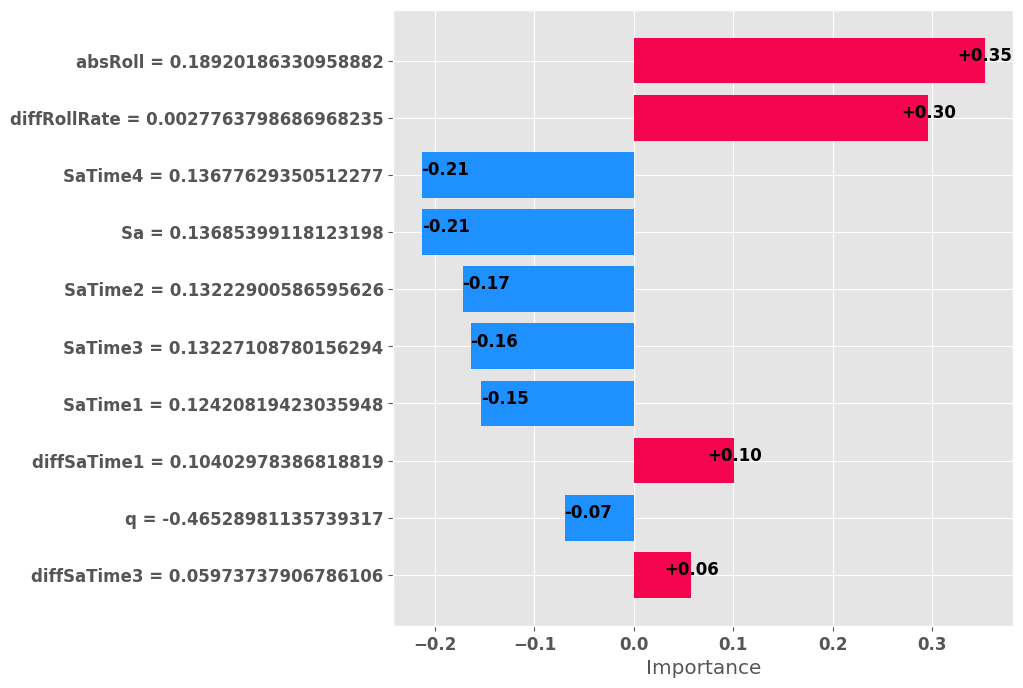

tensor([[0.2573]])

In [44]:
top_n = 10
ind = np.random.choice(len(test))

kan_model.plot_bars(test[ind][0].reshape(1, len(index_to_name)).to(device), test_data.iloc[0], top_n)
kan_model.predict(test[ind][0].reshape(1, len(index_to_name)).to(device))

In [50]:
value = next(iter(test_dataloader))

value[0].shape

torch.Size([64, 18])

## Implementing it in a more abstract way

In [16]:
from abc import ABC, abstractmethod

class PhiModel(ABC):
    """
    Any implementation must:
      - provide a forward(x) → (y_raw, phi)  where y_raw = sum(phi)
      - expose its parameters so we can backprop
    """
    @abstractmethod
    def forward(self, X):
        """
        X: np.ndarray or Tensor, shape (batch, d)
        returns:
          y_raw: shape (batch, 1)
          phi:   shape (batch, d)
        """
        pass

    @abstractmethod
    def parameters(self):
        """Return an iterable of parameters to optimize."""
        pass

class LossFunction(ABC):
    """A generic loss function that can look at (y, y_true, phi, model, ...)"""
    @abstractmethod
    def __call__(self, y_pred, y_true, phi, model, **kwargs):
        """Return a scalar loss in the backend's tensor type (with grad)."""
        pass

class Optimizer(ABC):
    """A minimal optimizer interface: zero_grad, step."""
    @abstractmethod
    def zero_grad(self):
        pass

    @abstractmethod
    def step(self):
        pass


In [17]:
import numpy as np
from typing import Iterator, Tuple

def iterate_minibatches(
    X: np.ndarray,
    y: np.ndarray,
    batch_size: int = 32,
    shuffle: bool = True
) -> Iterator[Tuple[np.ndarray, np.ndarray]]:
    """
    Yield successive (X_batch, y_batch) tuples from the dataset.

    Parameters
    ----------
    X : np.ndarray, shape (n_samples, n_features)
        Feature matrix.
    y : np.ndarray, shape (n_samples,) or (n_samples, n_targets)
        Target vector or matrix.
    batch_size : int
        Number of samples per batch.
    shuffle : bool
        Whether to shuffle the data before each epoch.

    Yields
    ------
    X_batch : np.ndarray, shape (batch_size, n_features)
    y_batch : np.ndarray, shape (batch_size,) or (batch_size, n_targets)
    """
    n_samples = X.shape[0]
    indices = np.arange(n_samples)
    if shuffle:
        np.random.shuffle(indices)

    for start in range(0, n_samples, batch_size):
        end = start + batch_size
        batch_idx = indices[start:end]
        yield X[batch_idx], y[batch_idx]


In [18]:
class ViaSHAP:
    def __init__(
        self,
        phi_model:      PhiModel,
        optimizer:      Optimizer,
        pred_loss:      LossFunction,
        shap_loss:      LossFunction,
        beta:           float = 1.0
    ):
        self.phi_model = phi_model
        self.opt       = optimizer
        self.pred_loss = pred_loss
        self.shap_loss = shap_loss
        self.beta      = beta

    def fit(self, X, y, epochs=10, batch_size=32):
        for epoch in range(epochs):
            for Xb, yb in iterate_minibatches(X, y, batch_size):
                self.opt.zero_grad()

                y_pred, _, phi = self.phi_model.forward(Xb)

                lp = self.pred_loss(y_pred, yb, phi, self.phi_model)
                ls = self.shap_loss(y_pred, yb, phi, self.phi_model, X=Xb)

                loss = lp + self.beta * ls

                loss.backward()
                self.opt.step()
        return self


In [19]:
import torch

def sample_shapley_mask(batch_size: int, d: int, device=None) -> torch.Tensor:
    """
    Returns a binary mask tensor M of shape (batch_size, d)
    where each row M[i] indicates a random subset S_i:
      - first sample k_i ~ Uniform({0,1,…,d})
      - then choose k_i distinct feature indices at random
    p(|S| = k) = 1/(d+1),  and  p(S | |S|=k) = 1/C(d, k)
    """
    device = device or torch.device("cpu")
    # 1) sample sizes
    sizes = torch.randint(low=0, high=d+1, size=(batch_size,), device=device)

    # 2) build masks
    mask = torch.zeros(batch_size, d, device=device, dtype=torch.float32)
    for i, k in enumerate(sizes.tolist()):
        if k > 0:
            # pick k distinct indices out of d
            idxs = torch.randperm(d, device=device)[:k]
            mask[i, idxs] = 1.0
    return mask


In [20]:
import torch, torch.nn as nn, torch.nn.functional as F

class TorchPhiModel(PhiModel, nn.Module):
    def __init__(self, input_dim, hidden_dim, link=torch.sigmoid):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )
        self.link = link

    def forward(self, X):
        phi = self.net(X)               # (batch, d)
        y_raw = phi.sum(dim=1, keepdim=True)
        y = self.link(y_raw)
        return y, y_raw, phi

    def parameters(self):
        # PyTorch modules already implement this,
        # so we can just defer to nn.Module.parameters:
        return super().parameters()

class MSELoss(LossFunction):
    def __call__(self, y_pred, y_true, phi, model, **kwargs):
        return F.mse_loss(y_pred, y_true)

class ShapRegLoss(LossFunction):
    def __init__(self, baseline, num_samples=5):
        self.baseline = baseline
        self.num_samples = num_samples

    def __call__(self, X, phi, model_forward):
        """
        X:    (batch, d)
        phi:  (batch, d)         # model's phi(x)
        model_forward: function  # returns y_raw when given X
        """
        device = X.device if hasattr(X, "device") else None
        baseline = self._get_baseline(X).to(device)

        losses = []
        for _ in range(self.num_samples):
            M = sample_shapley_mask(X.shape[0], X.shape[1], device=device)
            Xs = X * M + baseline * (1 - M)

            yS_raw = model_forward(Xs)            # shape (batch, 1)
            y0_raw = model_forward(baseline[None, :].expand_as(X))  # (batch, 1)
            delta  = (yS_raw - y0_raw).squeeze(1)  # (batch,)

            sum_phi_S = (phi * M).sum(dim=1)       # (batch,)
            losses.append((sum_phi_S - delta).pow(2))

        return torch.stack(losses).mean()



In [ ]:


via_shap = ViaSHAP(
    phi_model=TorchPhiModel(input_dim=X.shape[1], hidden_dim=100, link=torch.sigmoid),
    optimizer=torch.optim.Adam(phi_model.parameters(), lr=0.01),
    pred_loss=MSELoss(),
    shap_loss=ShapRegLoss(baseline=torch.zeros(X.shape[1], device=X.device))
)
